In [1]:
# 1. ADIM: Drive'ı bağla ve zip dosyasını aç
from google.colab import drive
import os

# Drive'ı bağla
drive.mount('/content/drive', force_remount=True)

# Zip dosyasının yolu (Senin dosya yapına göre)
zip_path = '/content/drive/MyDrive/Colab Notebooks/Deepfake_Proje/Dataset.zip'
extract_path = '/content/temp_data'

if os.path.exists(zip_path):
    print("Zip dosyası bulundu, çıkarılıyor...")
    !mkdir -p "$extract_path"
    !unzip -q "$zip_path" -d "$extract_path"
    print("Çıkarma işlemi tamamlandı!")
else:
    print("HATA: Dataset.zip dosyası belirtilen yolda bulunamadı! Klasör yolunu kontrol et.")

Mounted at /content/drive
Zip dosyası bulundu, çıkarılıyor...
replace /content/temp_data/Dataset/fake/id0_id17_0002.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Çıkarma işlemi tamamlandı!


In [2]:
# 2. ADIM: Videoları Bul ve Etiketle
import glob
import random
import numpy as np

# Zip'ten çıkan dosyaları bul
root_dir = '/content/temp_data'
# Eğer zip içinde 'Dataset' diye klasör varsa oraya bak, yoksa direkt köke bak
if os.path.exists(root_dir + '/Dataset'):
    root_dir = root_dir + '/Dataset'

real_videos = glob.glob(root_dir + '/real/*')
fake_videos = glob.glob(root_dir + '/fake/*')

print(f"Bulunan Real Video Sayısı: {len(real_videos)}")
print(f"Bulunan Fake Video Sayısı: {len(fake_videos)}")

# Etiketleri oluştur (Real: 1, Fake: 0)
video_paths = real_videos + fake_videos
labels = [1] * len(real_videos) + [0] * len(fake_videos)

# Verileri karıştır
combined = list(zip(video_paths, labels))
random.shuffle(combined)
video_paths, labels = zip(*combined)

# %80 Eğitim, %20 Test olarak ayır
split_idx = int(0.8 * len(video_paths))
train_paths = video_paths[:split_idx]
train_labels = labels[:split_idx]
valid_paths = video_paths[split_idx:]
valid_labels = labels[split_idx:]

print(f"Eğitim videosu: {len(train_paths)}, Test videosu: {len(valid_paths)}")

Bulunan Real Video Sayısı: 325
Bulunan Fake Video Sayısı: 342
Eğitim videosu: 533, Test videosu: 134


In [3]:
# 3. ADIM: Veri Okuyucu Sınıf
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

class video_dataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = []
        try:
            vidObj = cv2.VideoCapture(video_path)
            success = 1
            frame_list = []
            while success:
                success, image = vidObj.read()
                if success:
                    frame_list.append(image)

            # Videodan eşit aralıklarla kare seç
            if len(frame_list) > self.count:
                indices = np.linspace(0, len(frame_list)-1, self.count).astype(int)
                for i in indices:
                    frames.append(self.transform(frame_list[i]))
            else:
                for img in frame_list:
                     frames.append(self.transform(img))
                while len(frames) < self.count and len(frames) > 0:
                    frames.append(frames[-1])

            if len(frames) == 0:
                 return torch.zeros((self.count, 3, 112, 112)), label
        except:
            return torch.zeros((self.count, 3, 112, 112)), label

        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames, label

# Ayarlar
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# DataLoader oluştur
train_data = video_dataset(train_paths, train_labels, sequence_length=10, transform=train_transforms)
val_data = video_dataset(valid_paths, valid_labels, sequence_length=10, transform=train_transforms)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=2)

print("Veri yükleyiciler hazır!")

Veri yükleyiciler hazır!


In [4]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [5]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [7]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [8]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

[Epoch 1/20] [Batch 133 / 134] [Loss: 0.704333, Acc: 49.53%]Testing
[Batch 33 / 34]  [Loss: 0.692400, Acc: 52.99%]
Accuracy 52.985074626865675
[Epoch 2/20] [Batch 133 / 134] [Loss: 0.696869, Acc: 51.97%]Testing
[Batch 33 / 34]  [Loss: 0.697005, Acc: 52.24%]
Accuracy 52.23880597014925
[Epoch 3/20] [Batch 133 / 134] [Loss: 0.679954, Acc: 58.16%]Testing
[Batch 33 / 34]  [Loss: 0.692453, Acc: 55.97%]
Accuracy 55.97014925373134
[Epoch 4/20] [Batch 133 / 134] [Loss: 0.641691, Acc: 65.85%]Testing
[Batch 33 / 34]  [Loss: 0.722147, Acc: 48.51%]
Accuracy 48.507462686567166
[Epoch 5/20] [Batch 133 / 134] [Loss: 0.625227, Acc: 67.92%]Testing
[Batch 33 / 34]  [Loss: 0.727009, Acc: 52.24%]
Accuracy 52.23880597014925
[Epoch 6/20] [Batch 133 / 134] [Loss: 0.582678, Acc: 71.67%]Testing
[Batch 33 / 34]  [Loss: 0.785928, Acc: 49.25%]
Accuracy 49.25373134328358
[Epoch 7/20] [Batch 133 / 134] [Loss: 0.554546, Acc: 76.17%]Testing
[Batch 33 / 34]  [Loss: 0.908815, Acc: 49.25%]
Accuracy 49.25373134328358
[Epo

NameError: name 'plt' is not defined

--- KAYIP (LOSS) GRAFİĞİ ---
20


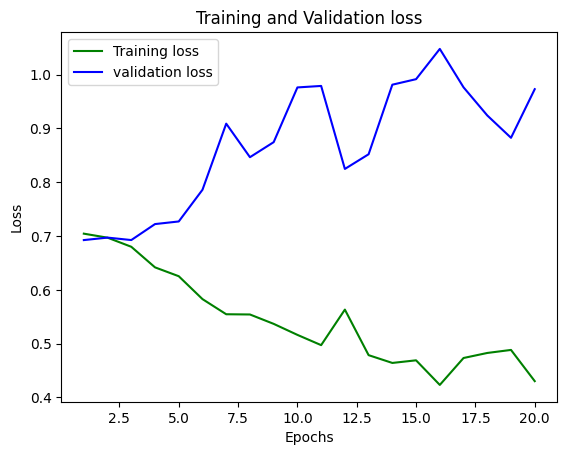


--- DOĞRULUK (ACCURACY) GRAFİĞİ ---


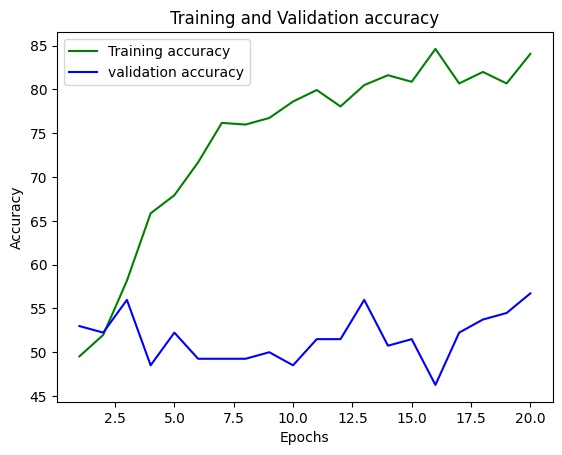


--- CONFUSION MATRIX (DOĞRU/YANLIŞ TABLOSU) ---
[[45 27]
 [31 31]]
True positive =  45
False positive =  27
False negative =  31
True negative =  31




NameError: name 'pd' is not defined

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Grafikleri tekrar ekrana getirelim
# (Veriler hafızada olduğu için yeniden eğitmeye gerek yok)

print("--- KAYIP (LOSS) GRAFİĞİ ---")
plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))

print("\n--- DOĞRULUK (ACCURACY) GRAFİĞİ ---")
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))

print("\n--- CONFUSION MATRIX (DOĞRU/YANLIŞ TABLOSU) ---")
# Confusion matrix verilerini ekrana bas
print(confusion_matrix(true, pred))
print_confusion_matrix(true, pred)

--- KAYIP (LOSS) GRAFİĞİ ---


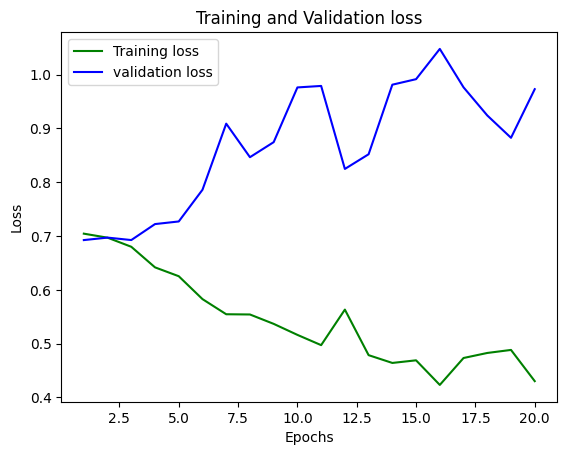


--- DOĞRULUK (ACCURACY) GRAFİĞİ ---


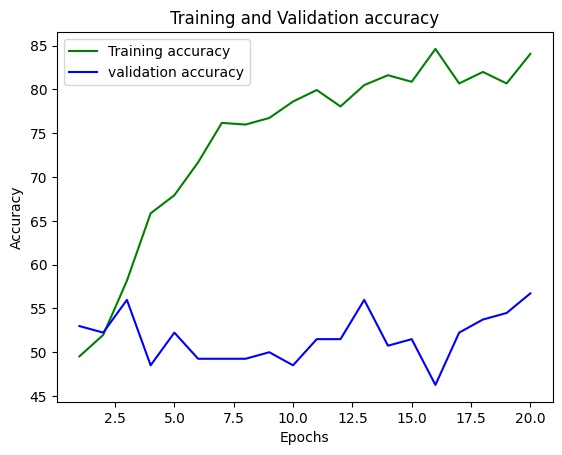


--- CONFUSION MATRIX (DOĞRU/YANLIŞ TABLOSU) ---
True positive =  45
False positive =  27
False negative =  31
True negative =  31




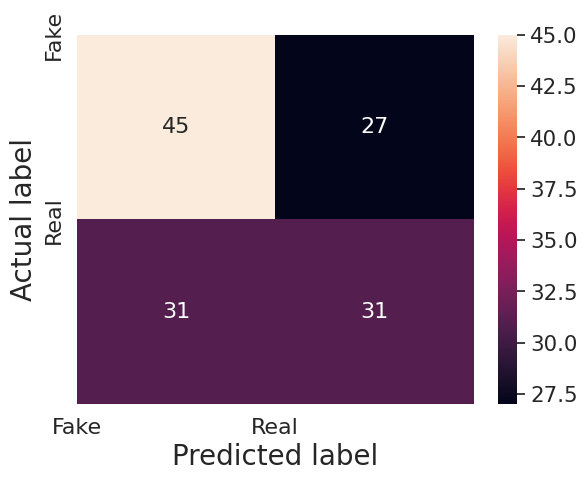

In [11]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# --- EĞER FONKSİYONLAR HAFIZADAN SİLİNDİYSE DİYE TEKRAR TANIMLIYORUZ ---
def plot_loss(train_loss_avg, test_loss_avg, num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  epochs = range(1, num_epochs + 1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_accuracy(train_accuracy, test_accuracy, num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1, num_epochs + 1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.show()

# --- GRAFİKLERİ ÇİZME KOMUTU ---
print("--- KAYIP (LOSS) GRAFİĞİ ---")
plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))

print("\n--- DOĞRULUK (ACCURACY) GRAFİĞİ ---")
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))

print("\n--- CONFUSION MATRIX (DOĞRU/YANLIŞ TABLOSU) ---")
print_confusion_matrix(true, pred)